In [ ]:
'''import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    print("Number of accelerators: ", len(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    print('TPU not found')'''

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-eec38d7c-aea3-ad5d-9b6e-1a032ae45371)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initialise GPU (only run when GPU is on)

In [ ]:
'''import os
import tensorflow as tf
import numpy as np

assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
    TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
    TF_MASTER = ''

tpu_address = TF_MASTER

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

print("All devices: ", tf.config.list_logical_devices('TPU'))
print("Number of devices: ", len(tf.config.list_logical_devices('TPU')))

strategy = tf.distribute.TPUStrategy(resolver)'''

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


Sorting out dataset (DO NOT RUN)

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# limits GPU VRAM consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Function to read and preprocess image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Function to read annotations and map to images
def read_annotations(csv_file):
    annotations_df = pd.read_csv(csv_file)
    images = []
    labels = []

    for filename in annotations_df['filename'].unique():
        image_path = os.path.join(os.path.dirname(csv_file), filename)
        images.append(image_path)

        # Extract bounding box coordinates for the image
        bboxes = annotations_df[annotations_df['filename'] == filename][['xmin', 'ymin', 'xmax', 'ymax', 'class']].values.tolist()
        bboxes_resized = [[int(coord * 0.4) for coord in box[:4]] + [box[4]] for box in bboxes]
        labels.append(bboxes_resized)

    return images, labels

# Load annotations for train, validation, and test sets
train_images, train_labels = read_annotations('/content/drive/My Drive/tr_dataset/train/_annotations.csv')
validation_images, validation_labels = read_annotations('/content/drive/My Drive/tr_dataset/valid/_annotations.csv')
test_images, test_labels = read_annotations('/content/drive/My Drive/tr_dataset/test/_annotations.csv')

print("Train image[0] is: ", train_images[0])
print("Train label[0] is: ", train_labels[0])

train_images = [preprocess_image(image) for image in train_images]
validation_images = [preprocess_image(image) for image in validation_images]
test_images = [preprocess_image(image) for image in test_images]

'''max_boxes = max(len(boxes) for boxes in train_labels + validation_labels + test_labels)
print("Max boxes is: ", max_boxes)

train_images = np.array(train_images)
train_labels = [np.pad(labels, ((0, max_boxes - len(labels)), (0, 0)), mode='constant', constant_values=0) for labels in train_labels]
train_labels = np.stack(train_labels, axis=0)

validation_images = np.array(validation_images)
validation_labels = [np.pad(labels, ((0, max_boxes - len(labels)), (0, 0)), mode='constant', constant_values=0) for labels in validation_labels]
validation_labels = np.stack(validation_labels, axis=0)

test_images = np.array(test_images)
test_labels = [np.pad(labels, ((0, max_boxes - len(labels)), (0, 0)), mode='constant', constant_values=0) for labels in test_labels]
test_labels = np.stack(test_labels, axis=0)'''


Train image[0] is:  /content/drive/My Drive/tr_dataset/train/syn_3726_jpg.rf.278b13b4872ea5382f9c0eb9e373c5db.jpg
Train label[0] is:  [[40, 23, 72, 118, '2'], [81, 24, 110, 120, 'T'], [145, 23, 177, 118, 'C'], [190, 23, 223, 119, 'M'], [26, 141, 58, 234, 'R'], [68, 141, 102, 236, 'E'], [109, 142, 144, 235, 'A'], [165, 142, 196, 234, 'Z'], [206, 143, 242, 235, 'A']]


'max_boxes = max(len(boxes) for boxes in train_labels + validation_labels + test_labels)\nprint("Max boxes is: ", max_boxes)\n\ntrain_images = np.array(train_images)\ntrain_labels = [np.pad(labels, ((0, max_boxes - len(labels)), (0, 0)), mode=\'constant\', constant_values=0) for labels in train_labels]\ntrain_labels = np.stack(train_labels, axis=0)\n\nvalidation_images = np.array(validation_images)\nvalidation_labels = [np.pad(labels, ((0, max_boxes - len(labels)), (0, 0)), mode=\'constant\', constant_values=0) for labels in validation_labels]\nvalidation_labels = np.stack(validation_labels, axis=0)\n\ntest_images = np.array(test_images)\ntest_labels = [np.pad(labels, ((0, max_boxes - len(labels)), (0, 0)), mode=\'constant\', constant_values=0) for labels in test_labels]\ntest_labels = np.stack(test_labels, axis=0)'

Create Dataset (DO NOT RUN)

In [ ]:
import os

# Define the directory to save cropped images
save_path = '/content/drive/My Drive/new_tr_test_dataset/'

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Iterate through train_images and train_labels
for i, (image, labels) in enumerate(zip(test_images, test_labels)):
    # Iterate through bounding boxes for each image
    for j, bbox in enumerate(labels):
        # Extract bounding box coordinates and class label
        xmin, ymin, xmax, ymax, char = bbox

        if int(xmin) == 0 and int(ymin) == 0 and int(xmax) == 0 and int(ymax) == 0:
          continue

        #print("bbox is: ", bbox)

        # Crop the bounding box from the image
        margin = 5
        xmin_expanded = max(0, int(xmin) - margin)
        ymin_expanded = max(0, int(ymin) - margin)
        xmax_expanded = min(image.shape[1], int(xmax) + margin)
        ymax_expanded = min(image.shape[0], int(ymax) + margin)

        # Crop the expanded bounding box from the image
        cropped_img = image[ymin_expanded:ymax_expanded, xmin_expanded:xmax_expanded]

        # Generate filename using the character label
        filename = f'{char}_{i}_{j}.jpg'

        # Save the cropped image to the designated path
        cv2.imwrite(os.path.join(save_path, filename), cropped_img)

print("Cropping and saving of images done!")


Cropping and saving of images done!


Create Dataset (DO NOT RUN)

In [ ]:
import os
import shutil

# Path to the folder containing the images
images_folder = '/content/drive/My Drive/new_tr_test_dataset/'

# Get a list of all files in the folder
image_files = os.listdir(images_folder)

# Iterate through each image file
for image_file in image_files:
    # Check if the file is a valid image file (you may want to add more image extensions)
    if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
        # Extract the first character of the filename
        first_char = image_file[0].upper()

        # Create the subfolder if it doesn't exist
        subfolder_path = os.path.join(images_folder, first_char)
        os.makedirs(subfolder_path, exist_ok=True)

        # Move the image file to the corresponding subfolder
        old_path = os.path.join(images_folder, image_file)
        new_path = os.path.join(subfolder_path, image_file)
        shutil.move(old_path, new_path)

print("Images sorted into subfolders successfully.")


Images sorted into subfolders successfully.


Merge two datasets together (DO NOT RUN)

In [ ]:
import os
import shutil

def merge_datasets(old_dataset_dir, new_dataset_dir):
    # Get list of labels (subfolder names) in the new dataset
    new_labels = os.listdir(new_dataset_dir)

    # Iterate over each label in the new dataset
    for label in new_labels:
        # Check if the label already exists in the old dataset
        if not os.path.exists(os.path.join(old_dataset_dir, label)):
            # If the label doesn't exist, create it in the old dataset
            os.makedirs(os.path.join(old_dataset_dir, label))

        # Get list of images in the current label folder of the new dataset
        images = os.listdir(os.path.join(new_dataset_dir, label))

        # Move each image from the new dataset to the corresponding label folder in the old dataset
        for image in images:
            # Construct source and destination paths
            src = os.path.join(new_dataset_dir, label, image)
            dst = os.path.join(old_dataset_dir, label, image)

            # Move the image
            shutil.move(src, dst)

    print("Dataset merged successfully.")

# Example usage
old_dataset_dir = '/content/drive/My Drive/new_tr_test_dataset/'
new_dataset_dir = '/content/drive/My Drive/archive7_testing/testing_data/'

merge_datasets(old_dataset_dir, new_dataset_dir)

def count_subfolders(folder_path):
    # Initialize a counter for subfolders
    num_subfolders = 0

    # Iterate over items in the folder
    for item in os.listdir(folder_path):
        # Check if the item is a directory (subfolder)
        if os.path.isdir(os.path.join(folder_path, item)):
            # Increment the counter
            num_subfolders += 1

    return num_subfolders

num_subfolders = count_subfolders(old_dataset_dir)
print("Number of subfolders:", num_subfolders)

Dataset merged successfully.
Number of subfolders: 36


Take small portion of dataset as it's taking too long (DO NOT RUN AGAIN)

In [ ]:
import os
import random
import shutil

def select_subset(dataset_dir, output_dir, num_images_per_class):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get list of class directories
    classes = os.listdir(dataset_dir)

    # Iterate over each class directory
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)

        # Create the output class directory
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        # Get list of image files in the class directory
        images = os.listdir(class_dir)

        # Randomly select num_images_per_class from the list of images
        selected_images = random.sample(images, min(num_images_per_class, len(images)))

        # Copy selected images to the output class directory
        for image in selected_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(output_class_dir, image)
            shutil.copyfile(src, dst)

    print("Subset created successfully.")

# Example usage
dataset_dir = '/content/drive/My Drive/new_tr_test_dataset/'
output_dir = '/content/drive/My Drive/new_tr_test_dataset_ref/'
num_images_per_class = 45

select_subset(dataset_dir, output_dir, num_images_per_class)


Subset created successfully.


Train Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

'''gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)'''

def custom_preprocessing(image):
    try:
        # Perform any preprocessing steps here
        return image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing
)

validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing)

def custom_generator(generator):
    while True:
        try:
            data = next(generator)
            if data is None:
                continue
            yield data
        except Exception as e:
            print(f"Error generating batch: {e}")


train_gen = datagen.flow_from_directory(
    '/content/drive/My Drive/new_tr_dataset_ref',
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse'
)

train_generator = custom_generator(train_gen)

validation_gen = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/new_tr_valid_dataset_ref',
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse'
)

validation_generator = custom_generator(validation_gen)

'''with tf.device(device_name):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(36, activation='softmax')
    ])

    checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/best_tr_model1/best_model.h5",
                                save_best_only=True,
                                ) # cant use checkpoint if using TPU. lr modified to 0.0008 since TPU has 8 cores. Higher batch number for TPU.
    early_stopping = EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True)

    lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.1, min_lr=1e-7)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=len(train_gen),
            epochs=20, validation_data=validation_generator,
            validation_steps=len(validation_gen), callbacks=[checkpoint, early_stopping, lr_plateau])

print("Model training done! ")
model.save('/content/drive/My Drive/new_tr_model')'''

# Pre-trained model
#with tf.device(device_name):
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(36, activation='softmax')
])

checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/best_tr_pretrained_model/best_model.h5",
                            save_best_only=True,
                            )
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.1, min_lr=1e-7)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator,
          steps_per_epoch=len(train_gen),
          epochs=50,
          validation_data=validation_generator,
          validation_steps=len(validation_gen), callbacks=[checkpoint, early_stopping, lr_plateau])

print("Model training done! ")
model.save('/content/drive/My Drive/new_tr_pretrained_model')

Found 7560 images belonging to 36 classes.
Found 1620 images belonging to 36 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
237/237 [==============================] - ETA: 0s - loss: 3.5196 - accuracy: 0.0651 Error generating batch: cannot identify image file <_io.BytesIO object at 0x78fce561b880>


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


237/237 [==============================] - 3422s 14s/step - loss: 3.5196 - accuracy: 0.0651 - val_loss: 3.2101 - val_accuracy: 0.2654 - lr: 1.0000e-04
Epoch 2/50
237/237 [==============================] - ETA: 0s - loss: 3.0810 - accuracy: 0.1717Error generating batch: cannot identify image file <_io.BytesIO object at 0x78fce5697ec0>
Error generating batch: cannot identify image file <_io.BytesIO object at 0x78fce56a0630>
237/237 [==============================] - 435s 2s/step - loss: 3.0810 - accuracy: 0.1717 - val_loss: 2.4643 - val_accuracy: 0.5142 - lr: 1.0000e-04
Epoch 3/50
237/237 [==============================] - 439s 2s/step - loss: 2.4956 - accuracy: 0.2996 - val_loss: 1.6681 - val_accuracy: 0.7426 - lr: 1.0000e-04
Epoch 4/50
237/237 [==============================] - 438s 2s/step - loss: 1.9866 - accuracy: 0.4298 - val_loss: 1.1475 - val_accuracy: 0.8481 - lr: 1.0000e-04
Epoch 5/50
Error generating batch: cannot identify image file <_io.BytesIO object at 0x78fce56bd260>
237/

Predict Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, Xception, DenseNet121

#tr_model = load_model('/content/drive/My Drive/best_tr_model/best_model.h5')

'''tr_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(36, activation='softmax')
])

tr_model.load_weights('/content/drive/My Drive/best_tr_model1/best_model.h5')'''

'''base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

tr_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(36, activation='softmax')
])'''

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

base_model.trainable = False

tr_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(36, activation='softmax')
])

tr_model.load_weights('/content/drive/My Drive/best_tr_pretrained_model/best_model.h5')


In [ ]:
import os
import cv2

test_images = []
test_labels = []


for i in os.listdir('/content/drive/My Drive/new_tr_test_dataset_ref/'):
    subfolder = os.path.join('/content/drive/My Drive/new_tr_test_dataset_ref/', i)
    files_in_subfolder_list = os.listdir(subfolder)
    for j in files_in_subfolder_list:
        image = os.path.join(subfolder, j)
        image = cv2.imread(image)
        image = cv2.resize(image, (64,64))
        image = np.array(image, dtype=np.float32)
        image = image / 255
        test_images.append(image)
        test_labels.append(i)

X_test = np.array(test_images)
y_test = np.array(test_labels)
print(X_test.shape)

le = LabelEncoder()
y_test = le.fit_transform(y_test)

predictions = tr_model.predict(X_test)

print(predictions.shape)

predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

(1203, 64, 64, 3)
38/38 [==============================] - 72s 2s/step
(1203, 36)


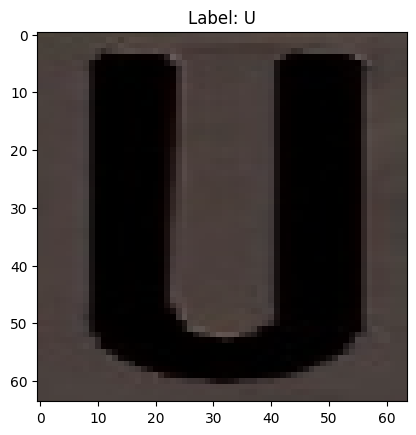

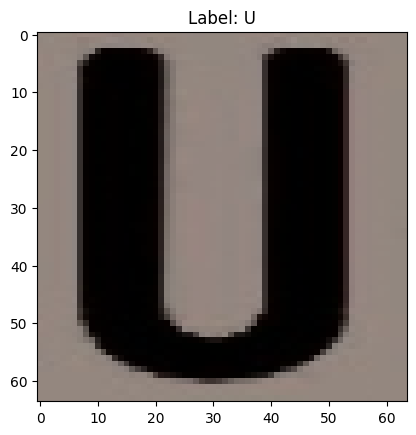

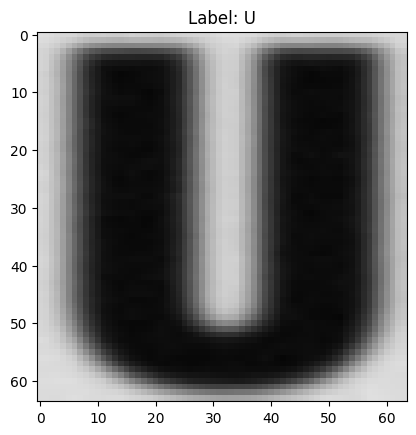

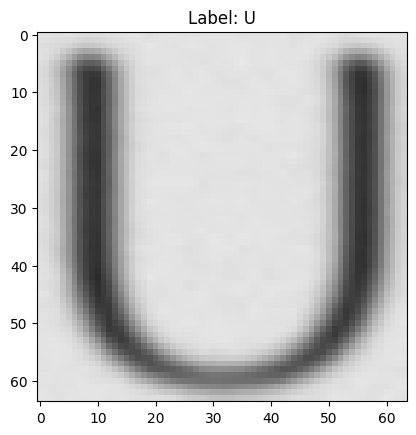

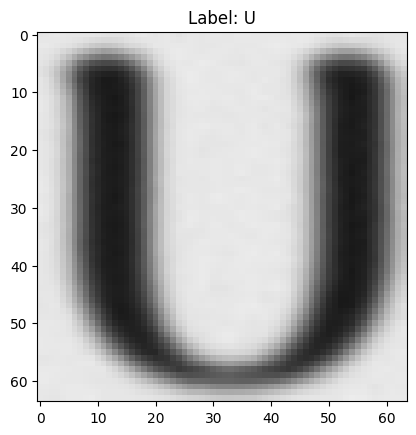

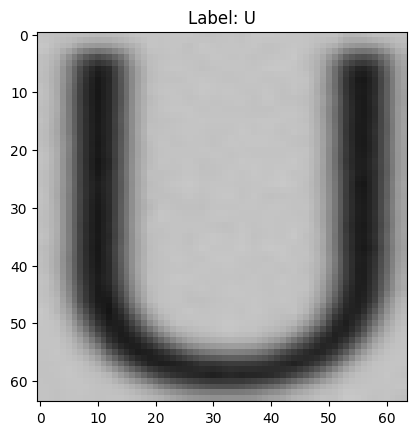

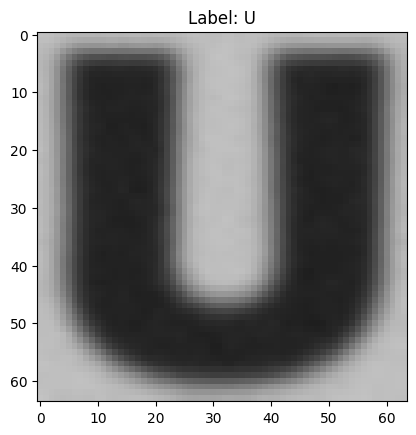

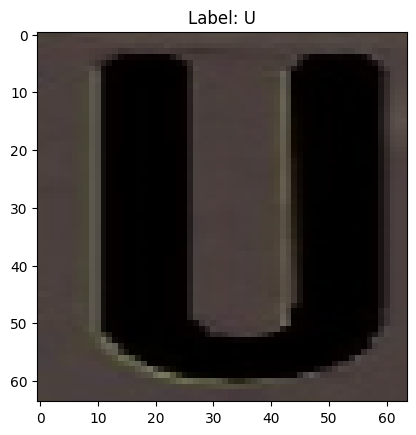

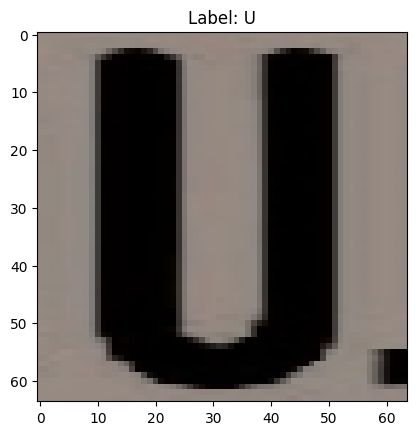

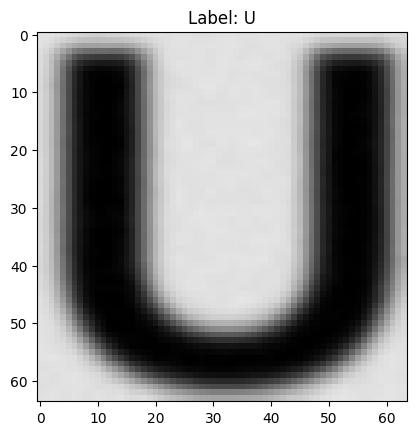

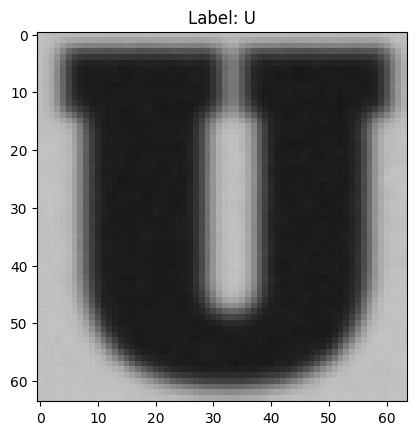

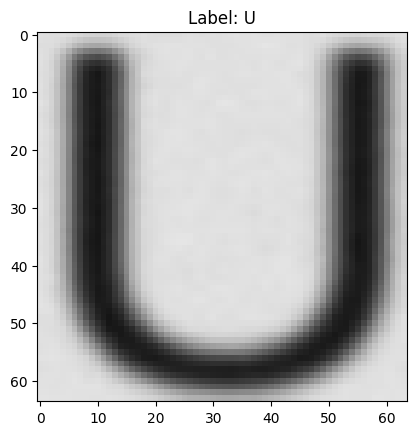

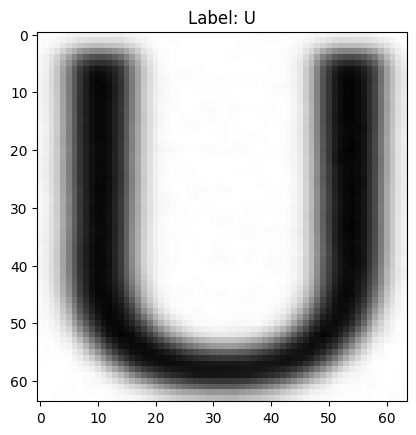

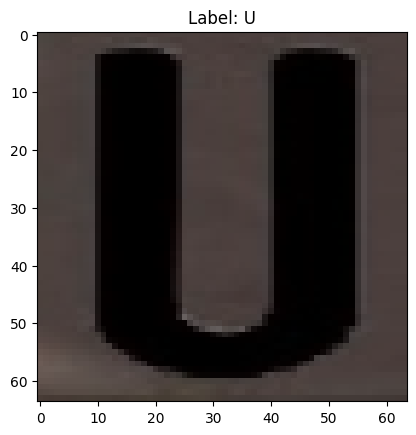

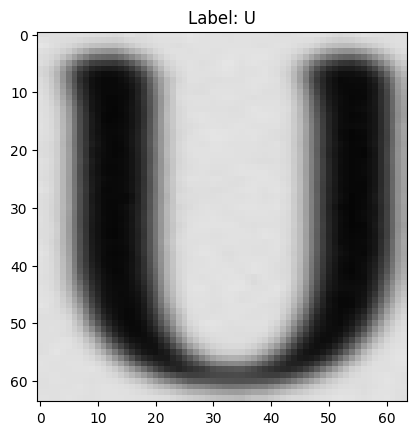

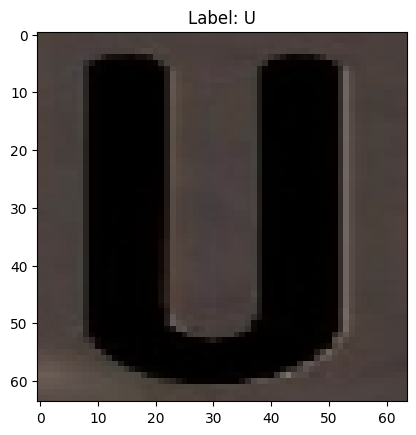

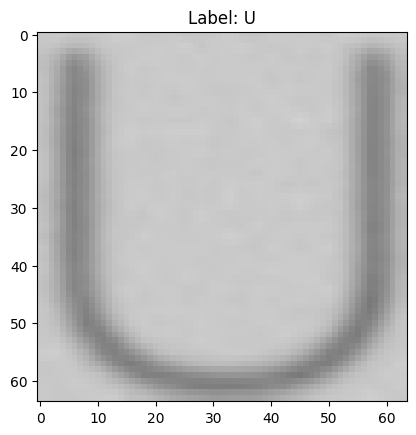

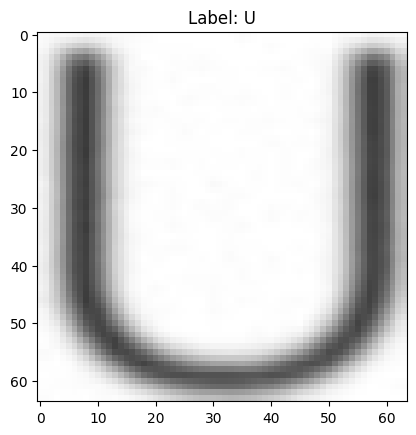

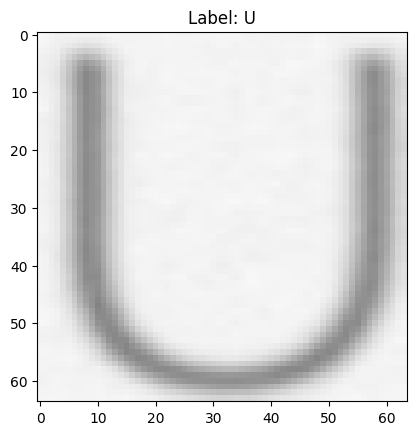

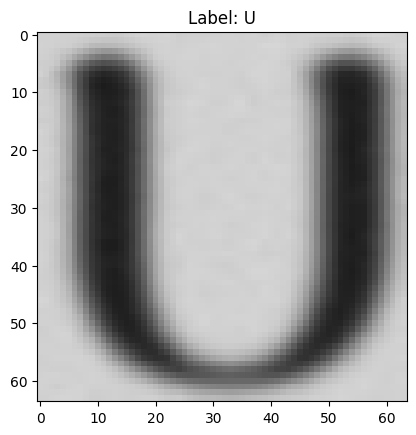

In [ ]:
for i in range(20):
    plt.imshow(X_test[i])
    plt.title(f"Label: {predicted_labels[i]}")
    plt.show()


In [ ]:
print("Classification report: ")
print(classification_report(test_labels, predicted_labels))

Classification report: 
              precision    recall  f1-score   support

           0       0.68      0.41      0.51        32
           1       0.76      1.00      0.86        34
           2       1.00      1.00      1.00        32
           3       1.00      0.94      0.97        35
           4       1.00      0.97      0.99        35
           5       1.00      0.94      0.97        35
           6       1.00      0.97      0.98        33
           7       1.00      1.00      1.00        34
           8       0.95      1.00      0.97        36
           9       1.00      0.95      0.97        39
           A       1.00      1.00      1.00        37
           B       0.97      0.97      0.97        36
           C       0.92      0.94      0.93        35
           D       1.00      0.97      0.98        33
           E       0.97      0.91      0.94        32
           F       0.91      0.97      0.94        31
           G       0.88      0.88      0.88        33
   

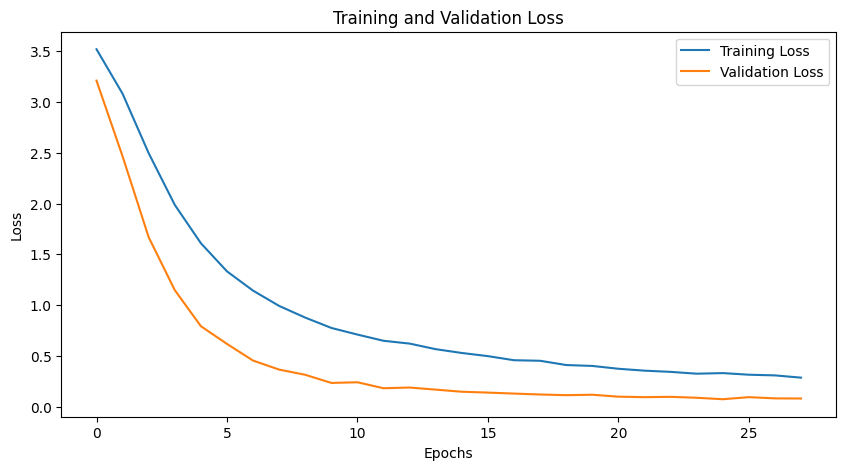

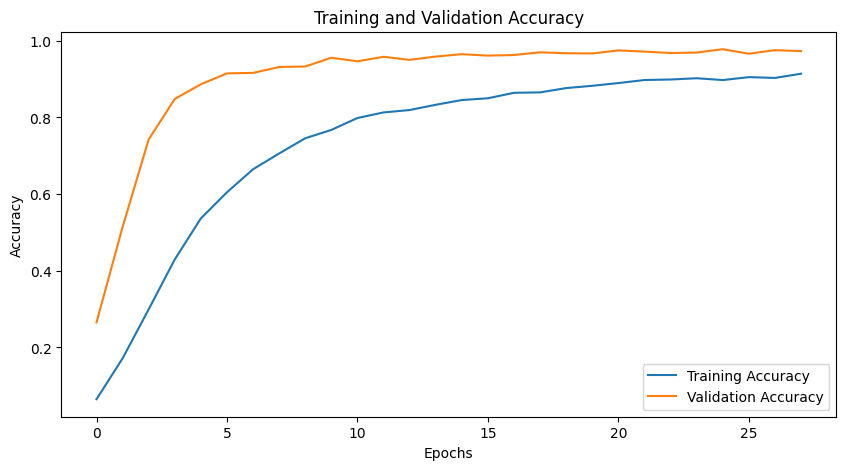

38/38 [==============================] - 52s 1s/step - loss: 0.1397 - accuracy: 0.9426
0.13973085582256317
0.942643404006958


In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Get training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy)

In [ ]:
image = cv2.imread('/content/drive/My Drive/new_tr_dataset/D/589.png')
#image = cv2.imread('/content/drive/My Drive/All-newKiaSportage21.jpg')
image = cv2.resize(image, (64, 64))  # Resize the image to match the input size of your model
image = np.array(image, dtype=np.float32) / 255.0  # Normalize the pixel values
image = np.expand_dims(image, axis=0)
predictions = tr_model.predict(image)
predicted_label = le.inverse_transform(np.argmax(predictions, axis=1))
print(predicted_label)

NameError: name 'cv2' is not defined